## Class 4-1: Supervised learning

In [15]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

Today we're going to look at GSS data asking people whether the government is spending too much or too little on various problems. We're going to try to predict one of the answers from all of the others.


### Exploring the data

In [16]:
# load it
gss = pd.read_csv('GSS-spending.csv')
gss.shape

(2869, 21)

In [17]:
# take a look
gss.head()

,Gss year for this respondent,Welfare,Highways and bridges,Social security,Mass transportation,Parks and recreation,Assistance for childcare,Supporting scientific research,Developing alternative energy sources,Foreign aid,...,Improving the conditions of blacks,Respondent id number,Space exploration program,Improving & protecting environment,Improving & protecting nations health,Solving problems of big cities,Halting rising crime rate,Dealing with drug addiction,Improving nations education system,Ballot used for interview
0,2016,About right,About right,Too much,Too little,About right,About right,About right,Too little,Too much,...,Too little,1.0,Too little,Too little,About right,About right,Too little,Too much,About right,Ballot a
1,2016,Don't know,Too little,Don't know,Too little,Too much,Too little,Don't know,Too little,Don't know,...,Too little,2.0,Don't know,Don't know,Too little,Don't know,Too much,Too little,Too little,Ballot b
2,2016,Don't know,Too little,Too little,Don't know,About right,Don't know,Don't know,Too little,Too much,...,About right,3.0,Too little,About right,Too little,Don't know,Too little,Too little,Too little,Ballot c
3,2016,Too much,About right,Too little,Too much,Too little,Too much,Too little,Too little,Too much,...,About right,4.0,About right,About right,Too much,About right,About right,Too little,Too little,Ballot a
4,2016,Not applicable,Too little,About right,Too little,Too much,Don't know,About right,About right,Not applicable,...,Not applicable,5.0,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot c


In [18]:
gss['Social security'].value_counts()

Too little     1690
About right     922
Too much        144
Don't know      108
No answer         3
Name: Social security, dtype: int64

In [19]:
# Our usual GSS cleanup

# drop the last two rows, which are just notes and do not contain data
gss = gss.iloc[0:-2,:]

# Drop some columns that don't contain useful information
gss = gss.drop(['Respondent id number',
                'Ballot used for interview',
                'Gss year for this respondent                       '], axis=1)

# recode answers on a -1, 0, 1 scale
gss = gss.replace({'Too little':-1, 'About right':0, 'Too much':1})

# Everything else gets NA
gss = gss.replace({'Not applicable' : None, 
                   'No answer' : None, 
                   'Don\'t know' : None})

gss.head()

,Welfare,Highways and bridges,Social security,Mass transportation,Parks and recreation,Assistance for childcare,Supporting scientific research,Developing alternative energy sources,Foreign aid,"Military, armaments, and defense",Improving the conditions of blacks,Space exploration program,Improving & protecting environment,Improving & protecting nations health,Solving problems of big cities,Halting rising crime rate,Dealing with drug addiction,Improving nations education system
0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0
1,NaN,-1.0,NaN,-1.0,1.0,-1.0,NaN,-1.0,NaN,1.0,-1.0,NaN,NaN,-1.0,NaN,1.0,-1.0,-1.0
2,NaN,-1.0,-1.0,NaN,0.0,NaN,NaN,-1.0,1.0,NaN,0.0,-1.0,0.0,-1.0,NaN,-1.0,-1.0,-1.0
3,1.0,0.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,-1.0
4,NaN,-1.0,0.0,-1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# For a decision tree to work we can't have any missing values. Drop all rows with any NAs
gss = gss.dropna(how='any')
gss.shape

(966, 18)

The simplest way to see if some variables are going to be predictable from others is to check out the overall correlations.

In [21]:
gss.corr()

,Welfare,Highways and bridges,Social security,Mass transportation,Parks and recreation,Assistance for childcare,Supporting scientific research,Developing alternative energy sources,Foreign aid,"Military, armaments, and defense",Improving the conditions of blacks,Space exploration program,Improving & protecting environment,Improving & protecting nations health,Solving problems of big cities,Halting rising crime rate,Dealing with drug addiction,Improving nations education system
Welfare,1.000000,-0.006757,0.155278,0.143237,0.070739,0.237646,0.102994,0.193061,0.237805,-0.164178,0.309208,0.061454,0.244432,0.272540,0.156629,0.056746,0.141378,0.183813
Highways and bridges,-0.006757,1.000000,0.026872,0.157222,0.093823,0.024875,0.152755,0.123248,-0.102287,0.087240,-0.002551,0.111460,0.004783,0.010164,0.064434,0.037119,0.031147,0.071355
Social security,0.155278,0.026872,1.000000,0.035626,0.016017,0.095636,0.046541,0.060742,-0.013267,0.154493,0.077135,-0.063929,0.054638,0.195731,0.127304,0.152562,0.112798,0.165547
Mass transportation,0.143237,0.157222,0.035626,1.000000,0.141974,0.162983,0.157084,0.210046,0.099832,-0.036082,0.200415,0.103661,0.186438,0.189207,0.155335,0.038188,0.081053,0.154244
Parks and recreation,0.070739,0.093823,0.016017,0.141974,1.000000,0.189808,0.132162,0.140942,0.124536,0.038513,0.086614,0.037409,0.129115,0.055493,0.049727,0.061445,0.118283,0.136432
Assistance for childcare,0.237646,0.024875,0.095636,0.162983,0.189808,1.000000,0.139225,0.149228,0.168914,-0.037380,0.332467,0.048239,0.287310,0.238023,0.169320,0.101540,0.232961,0.325700
Supporting scientific research,0.102994,0.152755,0.046541,0.157084,0.132162,0.139225,1.000000,0.301037,0.063412,0.022838,0.121517,0.282843,0.200086,0.095339,0.124031,0.022404,0.081014,0.122090
Developing alternative energy sources,0.193061,0.123248,0.060742,0.210046,0.140942,0.149228,0.301037,1.000000,0.083901,-0.082246,0.198386,0.157213,0.349311,0.150867,0.217295,0.053943,0.103840,0.257278
Foreign aid,0.237805,-0.102287,-0.013267,0.099832,0.124536,0.168914,0.063412,0.083901,1.000000,-0.072585,0.171882,0.063627,0.155224,0.101357,0.083383,0.003054,0.133562,0.055645
"Military, armaments, and defense",-0.164178,0.087240,0.154493,-0.036082,0.038513,-0.037380,0.022838,-0.082246,-0.072585,1.000000,-0.124476,-0.015785,-0.178785,-0.053051,0.012601,0.195340,0.047348,-0.015769


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1152f5cc0>,
      dtype=object)

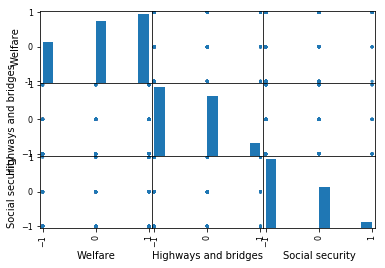

In [22]:
scatter_matrix(gss[[gss.columns[0], gss.columns[1], gss.columns[2]]])

### Building a decision-tree

We're going to use a machine learning technique called a decision tree to try to predict the answer on one question from the answers on all the others. 

In [23]:
# By changing this line and re-running the workbook, we can see how predictiable different variables are or aren't.
predict_col = 'Social security'
gss[predict_col].value_counts()

-1.0    573
 0.0    339
 1.0     54
Name: Social security, dtype: int64

Actually applying the decision tree is very much like doing a regresion.

In [24]:
# Fit a decision tree to the test data
x = gss.drop(predict_col, axis=1).values
y = gss[[predict_col]].values

dt = tree.DecisionTreeClassifier()
dt.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Ok, now we need to evaluate the result, by seeing how well it can predict our question from all the others. 

In [25]:
dt.predict(x)

array([ 1., -1., -1.,  0., -1.,  0.,  0., -1., -1., -1., -1., -1.,  0.,
       -1., -1., -1.,  0.,  0., -1.,  0.,  0., -1., -1., -1.,  0.,  0.,
       -1.,  0., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0., -1., -1.,
        0., -1., -1., -1.,  0., -1., -1.,  0., -1.,  0.,  0.,  0., -1.,
       -1., -1., -1., -1., -1.,  0.,  0., -1., -1., -1.,  0.,  1.,  0.,
       -1.,  0., -1.,  1., -1.,  0., -1., -1.,  0.,  0.,  0., -1.,  0.,
        0.,  0., -1., -1.,  0.,  0.,  0., -1.,  0., -1.,  0., -1.,  0.,
        0., -1., -1.,  0., -1., -1., -1.,  0.,  0., -1., -1., -1.,  0.,
       -1., -1.,  0., -1.,  0.,  1.,  1.,  1., -1.,  0., -1., -1.,  0.,
        0., -1.,  0., -1.,  0., -1.,  0., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  0.,  0., -1.,  1.,  0.,  1.,  0., -1., -1., -1.,  0.,
        0., -1.,  0., -1., -1.,  0., -1.,  0.,  1., -1., -1., -1.,  0.,
       -1., -1., -1., -1.,  0.,  0.,  0., -1., -1.,  0., -1.,  0.,  0.,
        0.,  0., -1., -1.,  1., -1., -1., -1.,  0., -1., -1., -1

In [26]:
# Get the predictions
y_pred = dt.predict(x)
y_pred[:10]

array([ 1., -1., -1.,  0., -1.,  0.,  0., -1., -1., -1.])

In [27]:
# What percentage did it predict right?
metrics.accuracy_score(y, y_pred)

0.9968944099378882

In [28]:
# What mistakes did it make?
pd.DataFrame(metrics.confusion_matrix(y, y_pred), 
             columns=['Predicted -1','Predicted 0','Predicted 1'],
             index=['True -1', 'True 0', 'True 1'])

,Predicted -1,Predicted 0,Predicted 1
True -1,572,1,0
True 0,1,338,0
True 1,0,1,53


So what is this tree thing? We can actually draw it 

To get this working, you will need to install `GraphViz`. On Windows, download it [here](https://graphviz.gitlab.io/download/). On Mac, try `brew install graphviz`


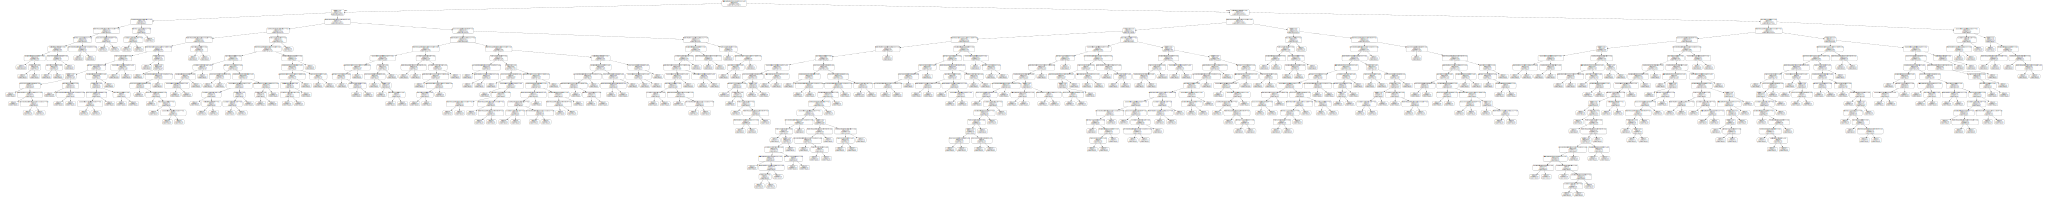

In [30]:
from sklearn.tree import export_graphviz
import graphviz

feature_names = gss.columns.drop(predict_col)
export_graphviz(dt, 
                feature_names=feature_names, 
                rounded=True,
                out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## A more realistic test
The test of a classifier is not whether it can reproduce the output training data -- it's how well it does on data it's never seen before. So let's split our data into training and test sets, and try this again.

In [31]:
# Split off a random third of this data to use for testing.
train, test = train_test_split(gss, test_size=0.3)

In [32]:
train.shape

(676, 18)

In [33]:
test.shape

(290, 18)

In [34]:
# The x values don't contain the column we want to predict. The y value is only that column.
x_train = train.drop(predict_col, axis=1).values
y_train = train[[predict_col]].values

x_test = test.drop(predict_col, axis=1).values
y_test = test[[predict_col]].values

In [35]:
# Fit a decision tree to the training data only
dt = tree.DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
# What percentage did it predict right on the training data?
y_train_pred = dt.predict(x_train)
metrics.accuracy_score(y_train, y_train_pred)

0.9970414201183432

In [37]:
# What percentage did it predict right on the test data?
y_test_pred = dt.predict(x_test)
metrics.accuracy_score(y_test, y_test_pred)

0.5275862068965518

In [38]:
# What mistakes did it make?
pd.DataFrame(metrics.confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted -1','Predicted 0','Predicted 1'],
             index=['True -1', 'True 0', 'True 1'])

,Predicted -1,Predicted 0,Predicted 1
True -1,113,54,9
True 0,54,36,6
True 1,8,6,4


## Random Forest: Improving accuracy with a better classifier

Sometimes improving accuracy is very difficult. You might just not have a very predictable problem! But we can often do better than just a simple decision tree, by using many trees. This is a "random forest," and for our purposes it's just a drop-in replacement for the classifier.

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
# What percentage did it predict right on the test data?
y_test_pred = rf.predict(x_test)
metrics.accuracy_score(y_test, y_test_pred)

0.5655172413793104

In [46]:
# What mistakes did it make?
pd.DataFrame(metrics.confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted -1','Predicted 0','Predicted 1'],
             index=['True -1', 'True 0', 'True 1'])

,Predicted -1,Predicted 0,Predicted 1
True -1,133,42,1
True 0,63,31,2
True 1,10,8,0


## Binary classification metrics
In this section we'll train a basic classifier on our favorite Titantic data, and then calculate some accuracy metrics for a binary predictor where there are only two outcomes: true and false. We'll be using these metrics over and over again in our upcoming discussions of algorithmic accountability.

For your reference, Wikipedia has an [amazing chart](https://en.wikipedia.org/wiki/Confusion_matrix) of the various things you can calculate from a binary confusion matrix.

In [27]:
# load titanic.csv once more
ti = pd.read_csv('titanic.csv')

In [28]:
# recode the pclass and gender variables so they are numeric
ti.pclass = ti.pclass.replace({'1st':1, '2nd':2, '3rd':3})
ti['female'] = ti.gender.replace({'male':0, 'female':1})

In [37]:
# Set aside a third of the data for testing.
ti_train, ti_test = train_test_split(ti, test_size=0.3, random_state=100)

In [38]:
# Set up x and y variables and train a decision tree on the pclass and sex features, to predict survived
feature_columns = ['pclass','female']
ti_x = ti_train[feature_columns].values
ti_y = ti_train[['survived']].values

dt = tree.DecisionTreeClassifier()
dt.fit(ti_x,ti_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
# Create ti_test and ti_test values, and use the classifier to predict yti_test_pred
ti_x_test = ti_test[feature_columns].values
ti_y_test = ti_test[['survived']].values
ti_y_test_pred = dt.predict(ti_x_test)

In [40]:
# Print out the confusion matrix for the classifier. Use the DataFrame trick we saw in class to label the axes.
pd.DataFrame(metrics.confusion_matrix(ti_y_test, ti_y_test_pred), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,255,2
True 1,65,72


In [47]:
# Ok! What are the number of true positives, true negatives, false positives, and false negatives?
TP = 72
TN = 255
FP = 2
FN = 65

In [43]:
# Using only the varaibles TP,TN,FP,FN, calculate and print the overall accuracy
accuracy = (TP+TN)/(TP+TN+FP+FN)
accuracy

0.8299492385786802

In [44]:
# Check that we have the calculation right by comparing to metrics.accuracy_score
metrics.accuracy_score(ti_y_test, ti_y_test_pred)

0.82994923857868019

In [45]:
# Using only the varaibles TP,TN,FP,FN, calculate and print the false positive rate and the false negative rate
FPR = FP/(FP+TN)
FPR

0.007782101167315175

In [46]:
FNR = FN/(FN+TP)
FNR

0.4744525547445255

In [47]:
# Now compute and print the precision aka positive predictive value, again from these four variables.
precision = TP/(TP+FP)
precision

0.972972972972973